In [1]:
#!/usr/bin/env python3

import os
import itertools
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import MDS
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

In [2]:
# Create directories for plots and intermediate data
PLOTS_DIR = "../pictures"
INTERMEDIATE_DATA_DIR = "../intermediate_data"
PATH_HPO = os.path.abspath("../ontologies/hpo.json")
PATH_MPO = os.path.abspath("../ontologies/mpo.json")

# function for further work with dataset
def isnan(x):
    return x != x

In [3]:
# dataset upload

data = pd.read_csv(
    "../databases/human_mouse_GPO_mono.tsv",
    delimiter="\t"
)

data.head()

,gene_human,entrez_id_human,gene_mouse,MGI,MP_HMD,MP_PhenoGeno,HP_genes_to_phenotype,MP_system_level,HP_system_level,MP_from_HP_system_level
0,A1BG,1,A1bg,MGI:2152878,NaN,NaN,NaN,NaN,NaN,NaN
1,A1CF,29974,A1cf,MGI:1917115,"MP:0005370,MP:0005376,MP:0005385,MP:0005397,MP...","MP:0006142,MP:0002833,MP:0004090,MP:0004084,MP...",NaN,"MP:0005370,MP:0005376,MP:0005385,MP:0005389,MP...",NaN,NaN
2,A2M,2,A2m,MGI:2449119,NaN,NaN,NaN,NaN,NaN,NaN
3,A3GALT2,127550,A3galt2,MGI:2685279,NaN,NaN,NaN,NaN,NaN,NaN
4,A4GALT,53947,A4galt,MGI:3512453,"MP:0010768,MP:0005376,MP:0005386","MP:0009747,MP:0008874,MP:0009767","HP:0000006,HP:0010970","MP:0010768,MP:0005376,MP:0005386",HP:0001871,MP:0005397


Mouse clustering preprocess

In [7]:
# All low-level MPs list

mp_exists = data[
    data.MP_PhenoGeno\
        .apply(lambda x: not isnan(x))
]

mps_low_raw = mp_exists.MP_PhenoGeno\
    .apply(lambda x: x.split(","))\
    .tolist()

mps_low = list(set(list(itertools.chain(*mps_low_raw))))

In [8]:
# Dict MP low-level term: gene list creation

mouse_gene_pheno = [
    mp_exists.gene_human.tolist(),
    mp_exists.MP_PhenoGeno.tolist()
]

mouse_mps_dict = defaultdict(list)

for idx in range(len(mouse_gene_pheno[0])):
    gene = mouse_gene_pheno[0][idx]
    mps = mouse_gene_pheno[1][idx]

    for mp in mps.split(","):
        mouse_mps_dict[mp].append(gene)

In [9]:
# Jaccard indexes for each low-level MP pair count

jcrd_m_m = [[]]

for mp_1 in mps_low:
    jcrd_line = []
    for mp_2 in mps_low:
        jcrd_val = len(
            set(mouse_mps_dict[mp_1]).intersection(set(mouse_mps_dict[mp_2]))
        ) / len(set(mouse_mps_dict[mp_1]).union(set(mouse_mps_dict[mp_2])))
        jcrd_line.append(jcrd_val)
    jcrd_m_m.extend([jcrd_line])

jcrd_mouse_mouse = pd.DataFrame(
    jcrd_m_m[1:], 
    columns=mps_low, 
    index=mps_low
)

In [ ]:
# convert jaccard indexes to distances and save to csv

jcrd_distances_mouse = 1 - jcrd_mouse_mouse

jcrd_distances_mouse.to_csv(
    "../intermediate_data/clustering_mouse_low.csv"
)

Human clustering preprocess

In [ ]:
# All low-level HPs list

hp_exists = data[
    data.HP_genes_to_phenotype\
        .apply(lambda x: not isnan(x))
]

hps_low_raw = hp_exists.HP_genes_to_phenotype\
    .apply(lambda x: x.split(","))\
    .tolist()

hps_low = list(set(list(itertools.chain(*hps_low_raw))))

In [ ]:
# Dict HP low-level term: gene list creation

human_gene_pheno = [
    hp_exists.gene_human.tolist(),
    hp_exists.HP_genes_to_phenotype.tolist()
]

human_hps_dict = defaultdict(list)

for idx in range(len(human_gene_pheno[0])):
    gene = human_gene_pheno[0][idx]
    hps = human_gene_pheno[1][idx]

    for hp in hps.split(","):
        human_hps_dict[hp].append(gene)

In [ ]:
# Jaccard indexes for each low-level HP pair count

jcrd_h_h = [[]]

for hp_1 in hps_low:
    jcrd_line = []
    for hp_2 in hps_low:
        jcrd_val = len(
            set(human_hps_dict[hp_1]).intersection(set(human_hps_dict[hp_2]))
        ) / len(set(human_hps_dict[hp_1]).union(set(human_hps_dict[hp_2])))
        jcrd_line.append(jcrd_val)
    jcrd_h_h.extend([jcrd_line])

jcrd_human_human = pd.DataFrame(
    jcrd_h_h[1:], 
    columns=hps_low, 
    index=hps_low
)

In [ ]:
# convert jaccard indexes to distances and save to csv

jcrd_distances_human = 1 - jcrd_human_human

jcrd_distances_human.to_csv(
    "../intermediate_data/clustering_human_low.csv"
)

Clustering

In [4]:
mouse_distances = pd.read_csv(
    "../intermediate_data/clustering_mouse_low.csv",
    index_col=0
)

mouse_distances.head()

,MP:0004175,MP:0030200,MP:0012304,MP:0001176,MP:0000021,MP:0003197,MP:0004243,MP:0002379,MP:0008363,MP:0009980,...,MP:0005176,MP:0000423,MP:0000741,MP:0010734,MP:0020356,MP:0001034,MP:0004062,MP:0000217,MP:0012365,MP:0020568
MP:0004175,0.0,1.000000,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0
MP:0030200,1.0,0.000000,1.0,0.993056,1.0,1.0,1.0,1.0,1.0,1.0,...,0.975000,1.000000,1.0,1.0,1.000000,0.941176,1.0,1.0,1.0,1.0
MP:0012304,1.0,1.000000,0.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0
MP:0001176,1.0,0.993056,1.0,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,...,0.987654,0.972414,1.0,1.0,0.985915,0.985612,1.0,1.0,1.0,1.0
MP:0000021,1.0,1.000000,1.0,1.000000,0.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0


In [ ]:
dissimilarities = np.max(mouse_distances) - mouse_distances

/home/nadia/BI/BI_ML_2023/HW1/code/environment/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)


In [ ]:
mds = MDS(n_components=2, dissimilarity='precomputed')
coordinates = mds.fit_transform(dissimilarities)

/home/nadia/BI/BI_ML_2023/HW1/code/environment/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


<AxesSubplot: xlabel='0', ylabel='1'>

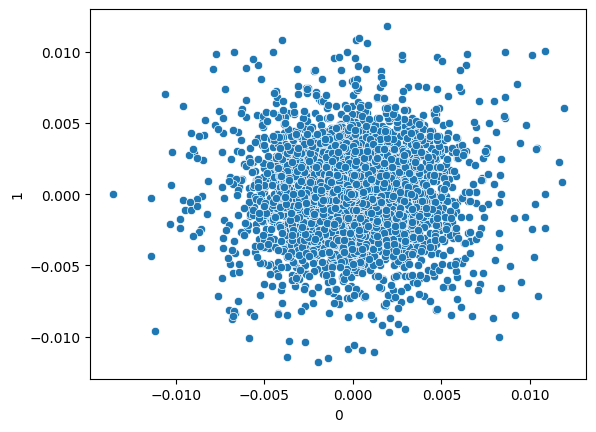

In [ ]:
sns.scatterplot(
    pd.DataFrame(coordinates), 
    x=0, y=1
)

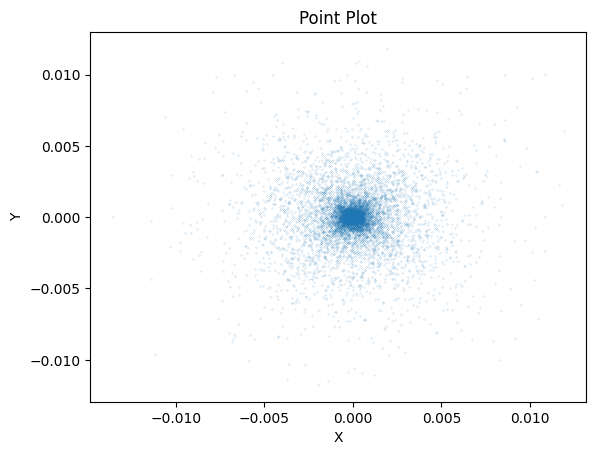

In [ ]:
plt.scatter(coordinates[:, 0], coordinates[:, 1],
            s=0.01)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Point Plot')
plt.show()

In [5]:
human_distances = pd.read_csv(
    "../intermediate_data/clustering_human_low.csv",
    index_col=0
)

human_distances.head()

,HP:0000190,HP:0005793,HP:0045028,HP:0001115,HP:0012330,HP:0025402,HP:0032531,HP:0030690,HP:0000751,HP:0031404,...,HP:0003193,HP:0030280,HP:0006673,HP:0006895,HP:0004444,HP:0032558,HP:0010906,HP:0100009,HP:0011109,HP:0009019
HP:0000190,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.956522,1.0,1.0,...,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,0.987179,1.0
HP:0005793,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,...,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0
HP:0045028,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,...,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0
HP:0001115,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.000000,1.0,1.0,...,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0
HP:0012330,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.000000,1.0,1.0,...,1.0,1.0,1.0,0.980769,1.0,1.0,1.0,1.0,1.000000,1.0


In [ ]:
dissimilarities = np.max(human_distances) - human_distances

mds = MDS(n_components=2, dissimilarity='precomputed')
coordinates = mds.fit_transform(dissimilarities)

/home/nadia/BI/BI_ML_2023/HW1/code/environment/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/nadia/BI/BI_ML_2023/HW1/code/environment/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


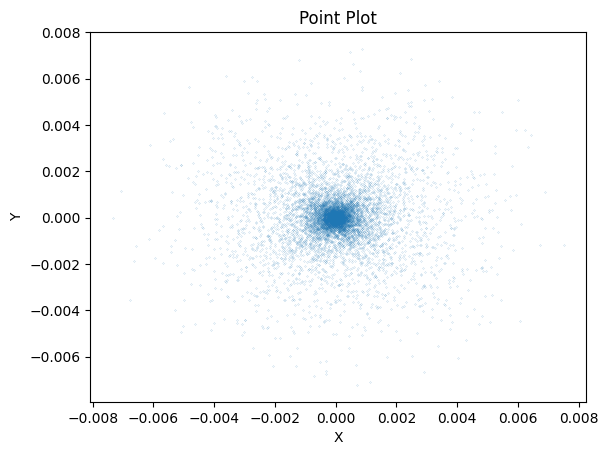

In [ ]:
plt.scatter(coordinates[:, 0], coordinates[:, 1],
            s=0.01)
plt.xlabel('X')
plt.ylabel('Y')
plt.title('Point Plot')
plt.show()

Plot silhouette score mouse

In [12]:
mouse_distances.head()

,MP:0004175,MP:0030200,MP:0012304,MP:0001176,MP:0000021,MP:0003197,MP:0004243,MP:0002379,MP:0008363,MP:0009980,...,MP:0005176,MP:0000423,MP:0000741,MP:0010734,MP:0020356,MP:0001034,MP:0004062,MP:0000217,MP:0012365,MP:0020568
MP:0004175,0.0,1.000000,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0
MP:0030200,1.0,0.000000,1.0,0.993056,1.0,1.0,1.0,1.0,1.0,1.0,...,0.975000,1.000000,1.0,1.0,1.000000,0.941176,1.0,1.0,1.0,1.0
MP:0012304,1.0,1.000000,0.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0
MP:0001176,1.0,0.993056,1.0,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,...,0.987654,0.972414,1.0,1.0,0.985915,0.985612,1.0,1.0,1.0,1.0
MP:0000021,1.0,1.000000,1.0,1.000000,0.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0


In [13]:
# Find the optimal number of clusters

mouse_sil = []

best_n_clusters = 2
best_silhouette_score = -1

for n_clusters in range(2, mouse_distances.shape[0], 50):
    clustering = AgglomerativeClustering(n_clusters=n_clusters, 
                                         metric='precomputed', 
                                         linkage='complete')
    cluster_labels = clustering.fit_predict(mouse_distances)

    silhouette_avg = silhouette_score(mouse_distances, 
                                      cluster_labels, 
                                      metric='precomputed')
    
    mouse_sil.append([n_clusters, silhouette_avg])

    # print(f"For {n_clusters} clusters, the average silhouette score is {silhouette_avg}")

    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_n_clusters = n_clusters

print(f"The optimal number of clusters is {best_n_clusters}")
print(f"The silhouette score is {best_silhouette_score}")

The optimal number of clusters is 5952
The silhouette score is 0.12537603328470298


In [14]:
# silhouette score clarification

for n_clusters in range(5900, 6000):
    clustering = AgglomerativeClustering(n_clusters=n_clusters, 
                                         metric='precomputed', 
                                         linkage='complete')
    cluster_labels = clustering.fit_predict(mouse_distances)

    silhouette_avg = silhouette_score(mouse_distances, 
                                      cluster_labels, 
                                      metric='precomputed')
    
    mouse_sil.append([n_clusters, silhouette_avg])

    # print(f"For {n_clusters} clusters, the average silhouette score is {silhouette_avg}")

    if silhouette_avg > best_silhouette_score:
        best_silhouette_score = silhouette_avg
        best_n_clusters = n_clusters

print(f"The optimal number of clusters is {best_n_clusters}")
print(f"The silhouette score is {best_silhouette_score}")

The optimal number of clusters is 5936
The silhouette score is 0.12542900350235936


In [33]:
np.min(np.array(mouse_sil)[:, 1])

-0.02022507682965622

''

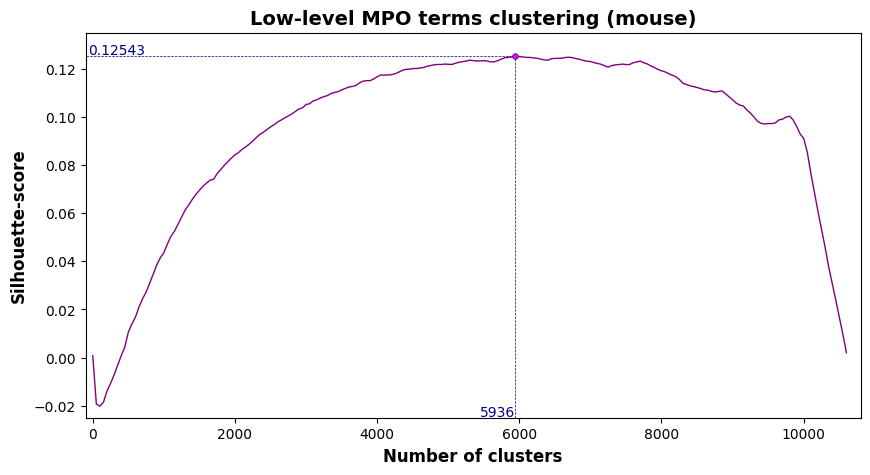

In [113]:
plt.figure(figsize=(10, 5))

clusters = np.array(mouse_sil)[:, 0]
silhouettes = np.array(mouse_sil)[:, 1]
sns.lineplot(
    x=clusters, 
    y=silhouettes,
    linewidth=1,
    color="purple"
)

ymin, ymax = -0.025, 0.135
plt.ylim(ymin, ymax)
xmin, xmax = -100, 10800
plt.xlim(xmin, xmax)

ymaxline = (best_silhouette_score - np.min(silhouettes)) / (ymax - np.min(silhouettes))
xmaxline = (best_n_clusters - np.min(clusters)) / (xmax - np.min(clusters))

lineset = {
    "linestyle": "--",
    "linewidth": 0.5,
    "color": "navy"
}

plt.axvline(
    x=best_n_clusters,
    ymax=ymaxline,
    **lineset
)
plt.axhline(
    y=best_silhouette_score,
    xmax=xmaxline,
    **lineset
)

plt.plot(
    best_n_clusters, 
    best_silhouette_score,
    color="magenta",
    marker="o",
    markersize=4,
    markeredgecolor="navy", 
    markeredgewidth=0.5
)

plt.annotate(
    text=best_n_clusters,
    xy=(best_n_clusters, ymin + 0.0005),
    ha="right",
    color="navy"
)
plt.annotate(
    text=f"{best_silhouette_score:.5f}",
    xy=(xmin + 30, best_silhouette_score + 0.0005),
    color="navy"
)

plt.xlabel(
    "Number of clusters",
    size=12,
    weight="semibold"
)
plt.ylabel(
    "Silhouette-score",
    size=12,
    weight="semibold"
)
plt.title(
    "Low-level MPO terms clustering (mouse)",
    size=14,
    weight="bold"
)

plt.savefig(
    f"{PLOTS_DIR}/concord_24_mouse_clustering",
    bbox_inches="tight",
    dpi=800
)
("")

Plot silhouette score human

In [100]:
# Find the optimal number of clusters

human_sil = []

best_n_clusters_2 = 2
best_silhouette_score_2 = -1

for n_clusters in range(2, human_distances.shape[0], 50):
    clustering = AgglomerativeClustering(n_clusters=n_clusters, 
                                         metric='precomputed', 
                                         linkage='complete')
    cluster_labels = clustering.fit_predict(human_distances)

    silhouette_avg = silhouette_score(human_distances, 
                                      cluster_labels, 
                                      metric='precomputed')
    
    human_sil.append([n_clusters, silhouette_avg])

    # print(f"For {n_clusters} clusters, the average silhouette score is {silhouette_avg}")

    if silhouette_avg > best_silhouette_score_2:
        best_silhouette_score_2 = silhouette_avg
        best_n_clusters_2 = n_clusters

print(f"The optimal number of clusters is {best_n_clusters_2}")
print(f"The silhouette score is {best_silhouette_score_2}")

The optimal number of clusters is 4902
The silhouette score is 0.2523610005016924


In [101]:
# silhouette score clarification

for n_clusters in range(4850, 5000):
    clustering = AgglomerativeClustering(n_clusters=n_clusters, 
                                         metric='precomputed', 
                                         linkage='complete')
    cluster_labels = clustering.fit_predict(human_distances)

    silhouette_avg = silhouette_score(human_distances, 
                                      cluster_labels, 
                                      metric='precomputed')
    
    human_sil.append([n_clusters, silhouette_avg])

    # print(f"For {n_clusters} clusters, the average silhouette score is {silhouette_avg}")

    if silhouette_avg > best_silhouette_score_2:
        best_silhouette_score_2 = silhouette_avg
        best_n_clusters_2 = n_clusters

print(f"The optimal number of clusters is {best_n_clusters_2}")
print(f"The silhouette score is {best_silhouette_score_2}")

The optimal number of clusters is 4900
The silhouette score is 0.25238565153918135


''

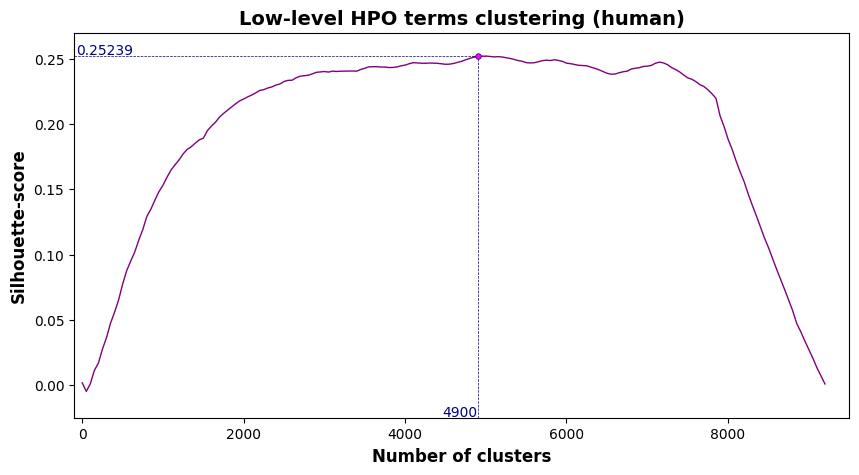

In [114]:
plt.figure(figsize=(10, 5))

clusters = np.array(human_sil)[:, 0]
silhouettes = np.array(human_sil)[:, 1]
sns.lineplot(
    x=clusters, 
    y=silhouettes,
    linewidth=1,
    color="purple"
)

ymin, ymax = -0.025, 0.27
plt.ylim(ymin, ymax)
xmin, xmax = -100, 9500
plt.xlim(xmin, xmax)

ymaxline = (best_silhouette_score_2 - np.min(silhouettes)) / (ymax - np.min(silhouettes))
xmaxline = (best_n_clusters_2 - np.min(clusters)) / (xmax - np.min(clusters))

lineset = {
    "linestyle": "--",
    "linewidth": 0.5,
    "color": "navy"
}

plt.axvline(
    x=best_n_clusters_2,
    ymax=ymaxline,
    **lineset
)
plt.axhline(
    y=best_silhouette_score_2,
    xmax=xmaxline,
    **lineset
)

plt.plot(
    best_n_clusters_2, 
    best_silhouette_score_2,
    color="magenta",
    marker="o",
    markersize=4,
    markeredgecolor="navy", 
    markeredgewidth=0.5
)

plt.annotate(
    text=best_n_clusters_2,
    xy=(best_n_clusters_2, ymin + 0.001),
    ha="right",
    color="navy"
)
plt.annotate(
    text=f"{best_silhouette_score_2:.5f}",
    xy=(xmin + 30, best_silhouette_score_2 + 0.001),
    color="navy"
)

plt.xlabel(
    "Number of clusters",
    size=12,
    weight="semibold"
)
plt.ylabel(
    "Silhouette-score",
    size=12,
    weight="semibold"
)
plt.title(
    "Low-level HPO terms clustering (human)",
    size=14,
    weight="bold"
)

plt.savefig(
    f"{PLOTS_DIR}/concord_25_human_clustering",
    bbox_inches="tight",
    dpi=800
)
("")

Applying best n_clusters for human and mouse and labeling the terms

In [3]:
best_n_clusters_m, best_n_clusters_h = 5936, 4900

In [7]:
clustering_m = AgglomerativeClustering(n_clusters=best_n_clusters_m, 
                                         metric='precomputed', 
                                         linkage='complete')
cluster_labels_m = clustering_m.fit_predict(mouse_distances)

In [8]:
dissimilarities_m = np.max(mouse_distances) - mouse_distances

mds_m = MDS(n_components=2, dissimilarity='precomputed')
coordinates_m = mds_m.fit_transform(dissimilarities_m)

/home/nadia/BI/BI_ML_2023/HW1/code/environment/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/nadia/BI/BI_ML_2023/HW1/code/environment/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


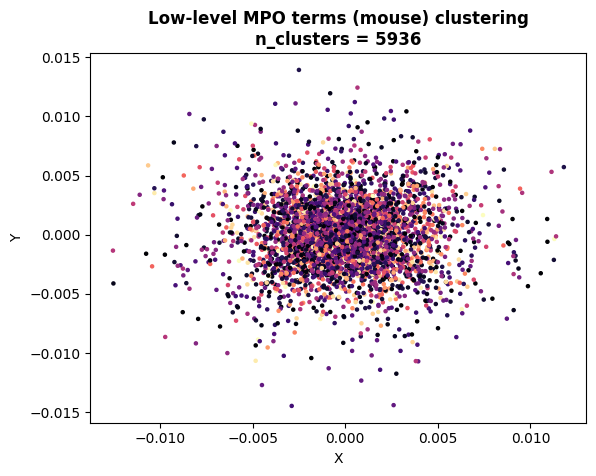

In [41]:
# plotting MPO terms with labels as colormap

# palette = sns.blend_palette(["navy", "crimson", "deeppink", "blueviolet"], as_cmap=True)

plt.scatter(
    coordinates_m[:, 0], 
    coordinates_m[:, 1],
    s=5, 
    c=cluster_labels_m,
    cmap="magma"
)
plt.xlabel("X")
plt.ylabel("Y")
plt.title(
    f"Low-level MPO terms (mouse) clustering\nn_clusters = {best_n_clusters_m}",
    weight="bold"
)

plt.savefig(
    f"{PLOTS_DIR}/concord_26_mouse_cluster_labels",
    bbox_inches="tight",
    dpi=800
)

plt.show()

In [6]:
clustering_h = AgglomerativeClustering(n_clusters=best_n_clusters_h, 
                                         metric='precomputed', 
                                         linkage='complete')
cluster_labels_h = clustering_h.fit_predict(human_distances)

dissimilarities_h = np.max(human_distances) - human_distances

mds_h = MDS(n_components=2, dissimilarity='precomputed')
coordinates_h = mds_h.fit_transform(dissimilarities_h)

/home/nadia/BI/BI_ML_2023/HW1/code/environment/lib/python3.9/site-packages/numpy/core/fromnumeric.py:84: FutureWarning: In a future version, DataFrame.max(axis=None) will return a scalar max over the entire DataFrame. To retain the old behavior, use 'frame.max(axis=0)' or just 'frame.max()'
  return reduction(axis=axis, out=out, **passkwargs)
/home/nadia/BI/BI_ML_2023/HW1/code/environment/lib/python3.9/site-packages/sklearn/manifold/_mds.py:299: FutureWarning: The default value of `normalized_stress` will change to `'auto'` in version 1.4. To suppress this warning, manually set the value of `normalized_stress`.
  warnings.warn(


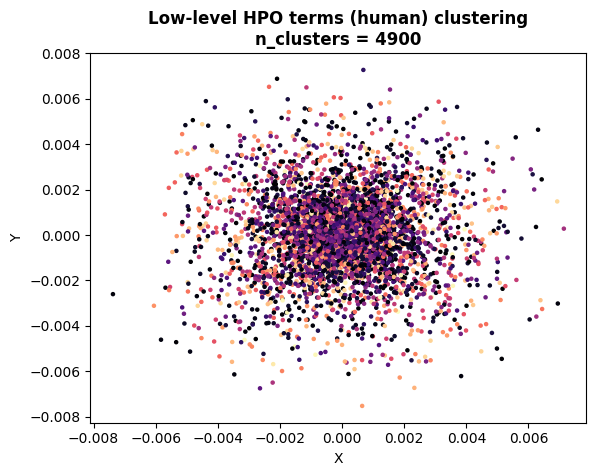

In [44]:
# plotting MPO terms with labels as colormap

plt.scatter(
    coordinates_h[:, 0], 
    coordinates_h[:, 1],
    s=5, 
    c=cluster_labels_h,
    cmap="magma"
)
plt.xlabel("X")
plt.ylabel("Y")
plt.title(
    f"Low-level HPO terms (human) clustering\nn_clusters = {best_n_clusters_h}",
    weight="bold"
)

plt.savefig(
    f"{PLOTS_DIR}/concord_27_human_cluster_labels",
    bbox_inches="tight",
    dpi=800
)

plt.show()

Work with clusters. First, let's have a look at values distribution

In [4]:
mouse_distances = pd.read_csv(
    "../intermediate_data/clustering_mouse_low.csv",
    index_col=0
)

mouse_distances.head()

,MP:0004175,MP:0030200,MP:0012304,MP:0001176,MP:0000021,MP:0003197,MP:0004243,MP:0002379,MP:0008363,MP:0009980,...,MP:0005176,MP:0000423,MP:0000741,MP:0010734,MP:0020356,MP:0001034,MP:0004062,MP:0000217,MP:0012365,MP:0020568
MP:0004175,0.0,1.000000,1.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0
MP:0030200,1.0,0.000000,1.0,0.993056,1.0,1.0,1.0,1.0,1.0,1.0,...,0.975000,1.000000,1.0,1.0,1.000000,0.941176,1.0,1.0,1.0,1.0
MP:0012304,1.0,1.000000,0.0,1.000000,1.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0
MP:0001176,1.0,0.993056,1.0,0.000000,1.0,1.0,1.0,1.0,1.0,1.0,...,0.987654,0.972414,1.0,1.0,0.985915,0.985612,1.0,1.0,1.0,1.0
MP:0000021,1.0,1.000000,1.0,1.000000,0.0,1.0,1.0,1.0,1.0,1.0,...,1.000000,1.000000,1.0,1.0,1.000000,1.000000,1.0,1.0,1.0,1.0


In [5]:
human_distances = pd.read_csv(
    "../intermediate_data/clustering_human_low.csv",
    index_col=0
)

human_distances.head()

,HP:0000190,HP:0005793,HP:0045028,HP:0001115,HP:0012330,HP:0025402,HP:0032531,HP:0030690,HP:0000751,HP:0031404,...,HP:0003193,HP:0030280,HP:0006673,HP:0006895,HP:0004444,HP:0032558,HP:0010906,HP:0100009,HP:0011109,HP:0009019
HP:0000190,0.0,1.0,1.0,1.0,1.0,1.0,1.0,0.956522,1.0,1.0,...,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,0.987179,1.0
HP:0005793,1.0,0.0,1.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,...,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0
HP:0045028,1.0,1.0,0.0,1.0,1.0,1.0,1.0,1.000000,1.0,1.0,...,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0
HP:0001115,1.0,1.0,1.0,0.0,1.0,1.0,1.0,1.000000,1.0,1.0,...,1.0,1.0,1.0,1.000000,1.0,1.0,1.0,1.0,1.000000,1.0
HP:0012330,1.0,1.0,1.0,1.0,0.0,1.0,1.0,1.000000,1.0,1.0,...,1.0,1.0,1.0,0.980769,1.0,1.0,1.0,1.0,1.000000,1.0


In [59]:
array_m = mouse_distances.values.flatten()
filt_arr_m = array_m[(array_m != 0) & (array_m != 1)]
filt_arr_m_2 = filt_arr_m[filt_arr_m < 0.5]

print("Mouse MPO-MPO terms similarity numbers.")
print(f"Number of MPO term - MPO term similarity values is {len(array_m)}.")
print(f"Number of non 0 and non 1 similarity values is {len(filt_arr_m)}.")
print(f"Number of non 0 and < 0.5 similarity values is {len(filt_arr_m_2)}.")

Mouse MPO-MPO terms similarity numbers.
Number of MPO term - MPO term similarity values is 113039424.
Number of non 0 and non 1 similarity values is 11630170.
Number of non 0 and < 0.5 similarity values is 828.


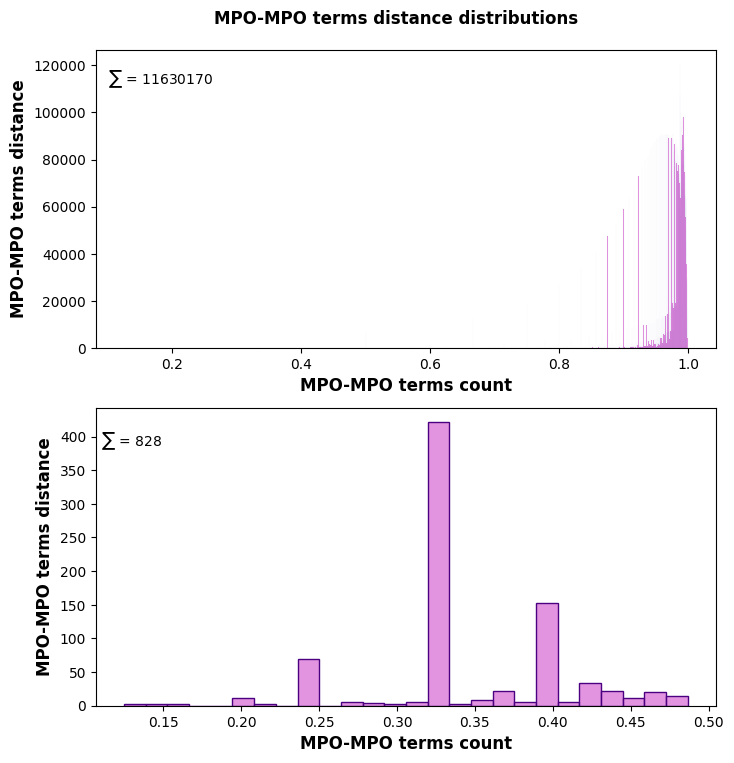

In [57]:
plt.figure(figsize=(8, 8))

dist_set = {
    "color": "orchid",
    "edgecolor": "indigo"
}

plt.subplot(2, 1, 1)

sns.histplot(
    filt_arr_m,
    **dist_set
)

plt.xlabel(
    "MPO-MPO terms count",
    weight="semibold",
    size=12
)
plt.ylabel(
    "MPO-MPO terms distance",
    weight="semibold",
    size=12
)

plt.text(
    0.1, 119000,
    s=fr"$\sum$ = {len(filt_arr_m)}",
    ha='left', va='top'
)

plt.subplot(2, 1, 2)

sns.histplot(
    filt_arr_m_2,
    **dist_set
)

plt.xlabel(
    "MPO-MPO terms count",
    weight="semibold",
    size=12
)
plt.ylabel(
    "MPO-MPO terms distance",
    weight="semibold",
    size=12
)

plt.text(
    0.11, 410,
    s=fr"$\sum$ = {len(filt_arr_m_2)}",
    ha='left', va='top'
)

plt.subplots_adjust(top=0.93)

plt.suptitle(
    "MPO-MPO terms distance distributions",
    weight="bold"
)

plt.savefig(
    f"{PLOTS_DIR}/concord_28_MPO_interactions_dist",
    bbox_inches="tight",
    dpi=800
)

plt.show()

In [60]:
array_h = human_distances.values.flatten()
filt_arr_h = array_h[(array_h != 0) & (array_h != 1)]
filt_arr_h_2 = filt_arr_h[filt_arr_h < 0.5]

print("Mouse HPO-HPO similarity numbers.")
print(f"Number of HPO term - HPO term similarity values is {len(array_h)}.")
print(f"Number of non 0 and non 1 similarity values is {len(filt_arr_h)}.")
print(f"Number of non 0 and < 0.5 similarity values is {len(filt_arr_h_2)}.")

Mouse HPO-HPO similarity numbers.
Number of HPO term - HPO term similarity values is 84824100.
Number of non 0 and non 1 similarity values is 5357684.
Number of non 0 and < 0.5 similarity values is 6960.


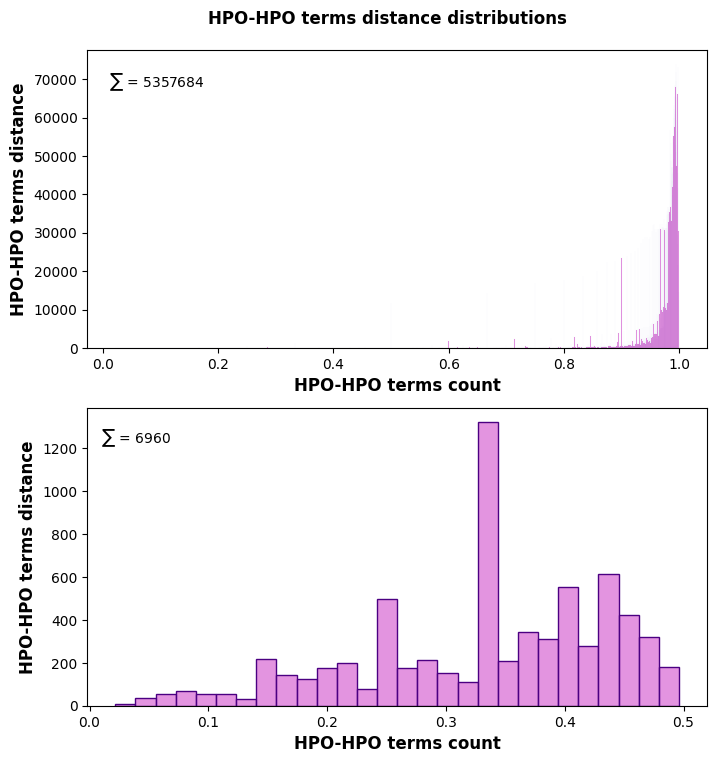

In [64]:
plt.figure(figsize=(8, 8))

dist_set = {
    "color": "orchid",
    "edgecolor": "indigo"
}

plt.subplot(2, 1, 1)

sns.histplot(
    filt_arr_h,
    **dist_set
)

plt.xlabel(
    "HPO-HPO terms count",
    weight="semibold",
    size=12
)
plt.ylabel(
    "HPO-HPO terms distance",
    weight="semibold",
    size=12
)

plt.text(
    0.01, 72000,
    s=fr"$\sum$ = {len(filt_arr_h)}",
    ha='left', va='top'
)

plt.subplot(2, 1, 2)

sns.histplot(
    filt_arr_h_2,
    **dist_set
)

plt.xlabel(
    "HPO-HPO terms count",
    weight="semibold",
    size=12
)
plt.ylabel(
    "HPO-HPO terms distance",
    weight="semibold",
    size=12
)

plt.text(
    0.01, 1300,
    s=fr"$\sum$ = {len(filt_arr_h_2)}",
    ha='left', va='top'
)

plt.subplots_adjust(top=0.93)

plt.suptitle(
    "HPO-HPO terms distance distributions",
    weight="bold"
)

plt.savefig(
    f"{PLOTS_DIR}/concord_29_HPO_interactions_dist",
    bbox_inches="tight",
    dpi=800
)

plt.show()

Cluster analysis

Mean distance within each cluster calculation

In [108]:
# Mouse

print(len(cluster_labels_m))
print(mouse_distances.shape)
print(len(np.unique(cluster_labels_m)))

10632
(10632, 10632)
5936


In [13]:
# mean distance within each cluster calculation

distance_means_m = []

for cluster_id in range(len(np.unique(cluster_labels_m))):
    rows_n_columns = np.where(cluster_labels_m == cluster_id)[0] # get indices of MPs within cluster
    df = mouse_distances.iloc[rows_n_columns, rows_n_columns] # slice the df
    array = df.to_numpy() # convert to numpy
    diagonal_indices = np.diag_indices(array.shape[0]) # get indices of diagonales
    np.fill_diagonal(array, np.nan) # diagonales -> nan
    mean = np.nanmean(array) # mean of distances
    size = len(rows_n_columns) # number of terms in cluster
    distance_means_m.append([cluster_id, mean, size])

/tmp/ipykernel_5550/2845221796.py:11: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(array) # mean of distances


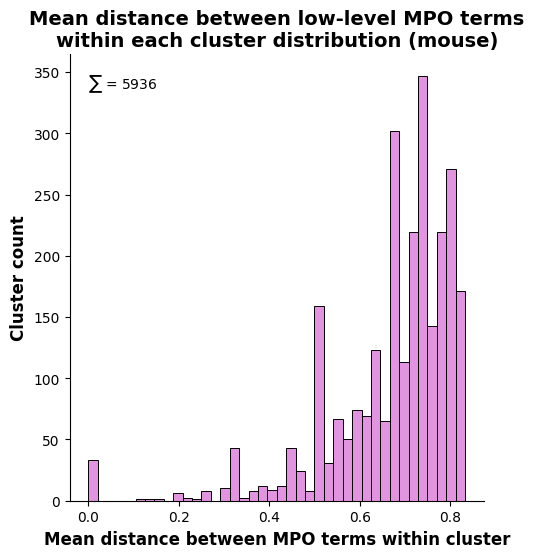

In [106]:
sns.displot(
    np.array(distance_means_m)[:, 1],
    color="orchid"
)

plt.xlabel(
    "Mean distance between MPO terms within cluster",
    size=12,
    weight="semibold"
)
plt.ylabel(
    "Cluster count",
    size=12,
    weight="semibold"
)
plt.text(
    0, 350,
    s=fr"$\sum$ = {len(np.unique(cluster_labels_m))}",
    ha='left', va='top'
)

plt.title(
    "Mean distance between low-level MPO terms\nwithin each cluster distribution (mouse)",
    size=14,
    weight="bold"
)

plt.savefig(
    f"{PLOTS_DIR}/concord_30_MPO_distance_within_cluster_dist",
    bbox_inches="tight",
    dpi=800
)

plt.show()

In [110]:
# Human

print(len(cluster_labels_h))
print(human_distances.shape)
print(len(np.unique(cluster_labels_h)))

9210
(9210, 9210)
4900


In [15]:
# mean distance within each cluster calculation

distance_means_h = []

for cluster_id in range(len(np.unique(cluster_labels_h))):
    rows_n_columns = np.where(cluster_labels_h == cluster_id)[0] # get indices of MPs within cluster
    df = human_distances.iloc[rows_n_columns, rows_n_columns] # slice the df
    array = df.to_numpy() # convert to numpy
    diagonal_indices = np.diag_indices(array.shape[0]) # get indices of diagonales
    np.fill_diagonal(array, np.nan) # diagonales -> nan
    mean = np.nanmean(array) # mean of distances
    size = len(rows_n_columns) # number of terms in cluster
    distance_means_h.append([cluster_id, mean, size])

/tmp/ipykernel_5550/2590468033.py:11: RuntimeWarning: Mean of empty slice
  mean = np.nanmean(array) # mean of distances


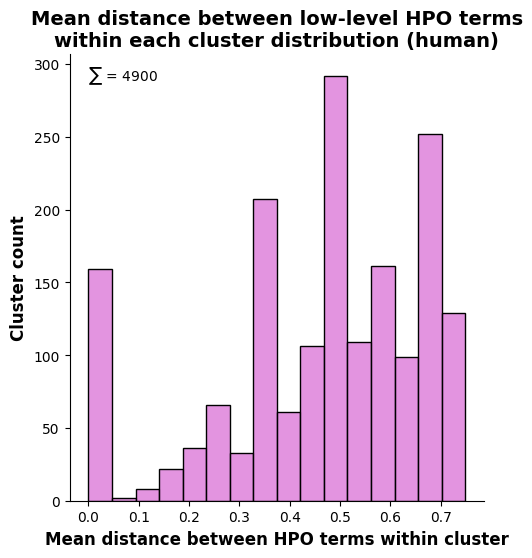

In [114]:
sns.displot(
    np.array(distance_means_h)[:, 1],
    color="orchid"
)

plt.xlabel(
    "Mean distance between HPO terms within cluster",
    size=12,
    weight="semibold"
)
plt.ylabel(
    "Cluster count",
    size=12,
    weight="semibold"
)
plt.text(
    0, 300,
    s=fr"$\sum$ = {len(np.unique(cluster_labels_h))}",
    ha='left', va='top'
)

plt.title(
    "Mean distance between low-level HPO terms\nwithin each cluster distribution (human)",
    size=14,
    weight="bold"
)

plt.savefig(
    f"{PLOTS_DIR}/concord_31_HPO_distance_within_cluster_dist",
    bbox_inches="tight",
    dpi=800
)

plt.show()

Show on scatter plots clusters with lowest distance within

In [36]:
# mouse
# np array with distance within cluster based on cluster label computation

distance_means_m_dict = dict(np.array(distance_means_m)[:, [0, 1]])
cluster_sizes_m_dict = dict(np.array(distance_means_m)[:, [0, 2]])
cluster_distances_m = np.array([distance_means_m_dict[key] for key in cluster_labels_m])
cluster_sizes_m = np.array([cluster_sizes_m_dict[key] for key in cluster_labels_m])

# df with all MPO low-level terms, cluster labels and within cluster distances

clustered_mps = pd.concat([
    pd.DataFrame(coordinates_m).rename(columns={0: "x", 1: "y"}), 
    pd.DataFrame(cluster_labels_m).rename(columns={0: "cluster_label"}), 
    pd.DataFrame(cluster_distances_m).rename(columns={0: "distance_within_cluster"}),
    pd.DataFrame(cluster_sizes_m).rename(columns={0: "cluster_size"})
], axis=1)

clustered_mps.to_csv(
    "../intermediate_data/clustered_mps_label_distance.csv"
)

In [29]:
# human
# np array with distance within cluster based on cluster label computation

distance_means_h_dict = dict(np.array(distance_means_h)[:, [0, 1]])
cluster_sizes_h_dict = dict(np.array(distance_means_h)[:, [0, 2]])
cluster_distances_h = np.array([distance_means_h_dict[key] for key in cluster_labels_h])
cluster_sizes_h = np.array([cluster_sizes_h_dict[key] for key in cluster_labels_h])

# df with all MPO low-level terms, cluster labels and within cluster distances

clustered_hps = pd.concat([
    pd.DataFrame(coordinates_h).rename(columns={0: "x", 1: "y"}), 
    pd.DataFrame(cluster_labels_h).rename(columns={0: "cluster_label"}), 
    pd.DataFrame(cluster_distances_h).rename(columns={0: "distance_within_cluster"}),
    pd.DataFrame(cluster_sizes_h).rename(columns={0: "cluster_size"})
], axis=1)

clustered_hps.to_csv(
    "../intermediate_data/clustered_hps_label_distance.csv"
)

In [192]:
clustered_mps.sort_values(by="distance_within_cluster")

,x,y,cluster_label,distance_within_cluster
7645,0.000114,-0.000135,2816,0.0
504,-0.000047,0.000110,3071,0.0
3670,-0.000094,0.000030,2081,0.0
8550,0.000047,-0.000190,5074,0.0
3897,-0.000161,-0.000012,5505,0.0
...,...,...,...,...
10604,-0.000141,-0.000673,1702,NaN
10606,-0.002560,0.001157,2141,NaN
10615,-0.000402,0.000069,1784,NaN
10616,-0.000012,0.000008,1863,NaN


Visualization.

In [5]:
best_n_clusters_m, best_n_clusters_h = 5936, 4900

In [6]:
clustered_mps = pd.read_csv(
    "../intermediate_data/clustered_mps_label_distance.csv",
    index_col=0
)
clustered_mps.head()

,x,y,cluster_label,distance_within_cluster,cluster_size
0,0.000478,0.000342,5488,NaN,1.0
1,0.002185,-0.005305,380,0.725211,4.0
2,-0.000009,-0.000240,811,0.513889,4.0
3,0.005389,-0.003051,2066,0.805195,2.0
4,0.000462,0.000003,333,0.604762,7.0


In [7]:
def color_set_m(x):
    if 0 <= x < 0.5:
        return "mediumturquoise"    
    elif 0.5 <= x <= 0.65:
        return "fuchsia"
    elif 0.65 < x <= 1:
        return "navy"
    else:
        return "black"

In [8]:
clustered_mps["color"] = clustered_mps\
    .distance_within_cluster\
    .apply(lambda x: color_set_m(x) if not isnan(x) else x)

clustered_mps.sort_values(by="distance_within_cluster", ascending=False)

,x,y,cluster_label,distance_within_cluster,cluster_size,color
4213,0.000051,0.000045,12,0.833333,2.0,navy
6492,-0.004226,-0.000923,0,0.833333,2.0,navy
1891,-0.001259,-0.002621,0,0.833333,2.0,navy
791,-0.000019,-0.000023,2,0.833333,2.0,navy
8,0.000005,-0.000062,2,0.833333,2.0,navy
...,...,...,...,...,...,...
10604,-0.000115,-0.000722,1702,NaN,1.0,NaN
10606,-0.001614,0.002873,2141,NaN,1.0,NaN
10615,0.000117,0.000190,1784,NaN,1.0,NaN
10616,0.000003,-0.000019,1863,NaN,1.0,NaN


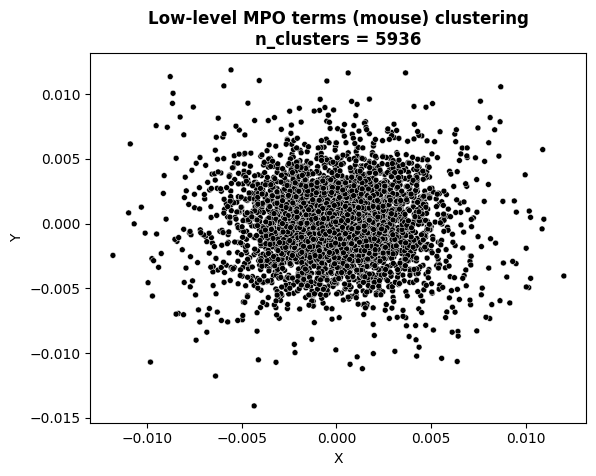

In [9]:
# plotting (mouse), distance within cluster as color hue, 
# cluster size as size hue

# color labels list
cols_m = np.array(clustered_mps.color.tolist())
mouse_colors = np.where(cols_m == "nan", "black", cols_m)
mouse_sizes = clustered_mps.cluster_size.tolist()

sns.scatterplot(
    data=clustered_mps,
    x="x",
    y="y",
    color="k",
    size=3,
    legend=False
)

plt.xlabel("X")
plt.ylabel("Y")
plt.title(
    f"Low-level MPO terms (mouse) clustering\nn_clusters = {best_n_clusters_m}",
    weight="bold"
)

plt.savefig(
    f"{PLOTS_DIR}/concord_32_mouse_clustered",
    bbox_inches="tight",
    dpi=800
)

plt.show()

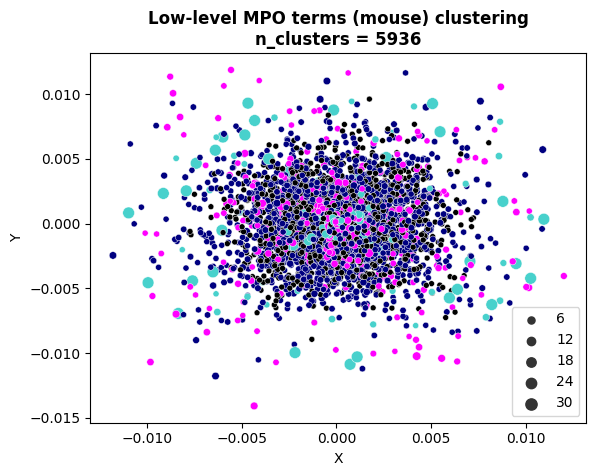

In [10]:
# plotting (mouse), distance within cluster as color hue, 
# cluster size as size hue

# color labels list
cols_m = np.array(clustered_mps.color.tolist())
mouse_colors = np.where(cols_m == "nan", "black", cols_m)
mouse_sizes = clustered_mps.cluster_size.tolist()

sns.scatterplot(
    data=clustered_mps,
    x="x",
    y="y",
    color=mouse_colors,
    size=mouse_sizes,
    legend=True
)

plt.xlabel("X")
plt.ylabel("Y")
plt.title(
    f"Low-level MPO terms (mouse) clustering\nn_clusters = {best_n_clusters_m}",
    weight="bold"
)

plt.savefig(
    f"{PLOTS_DIR}/concord_34_mouse_clustered_hue",
    bbox_inches="tight",
    dpi=800
)

plt.show()

In [11]:
print(clustered_mps.shape)
print(len(mouse_colors))

clustered_mps.head()

(10632, 6)
10632


,x,y,cluster_label,distance_within_cluster,cluster_size,color
0,0.000478,0.000342,5488,NaN,1.0,NaN
1,0.002185,-0.005305,380,0.725211,4.0,navy
2,-0.000009,-0.000240,811,0.513889,4.0,fuchsia
3,0.005389,-0.003051,2066,0.805195,2.0,navy
4,0.000462,0.000003,333,0.604762,7.0,fuchsia


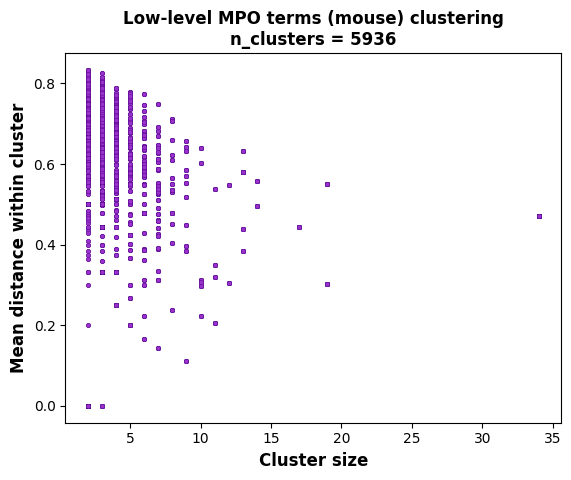

In [12]:
sns.scatterplot(
    data=clustered_mps,
    x="cluster_size",
    y="distance_within_cluster",
    s=10, c="darkorchid",
    edgecolor="indigo"
)

plt.xlabel(
    "Cluster size",
    size=12,
    weight="bold"
)
plt.ylabel(
    "Mean distance within cluster",
    size=12,
    weight="bold"
)
plt.title(
    f"Low-level MPO terms (mouse) clustering\nn_clusters = {best_n_clusters_m}",
    weight="bold"
)

plt.savefig(
    f"{PLOTS_DIR}/concord_36_mouse_custer_size_distance",
    bbox_inches="tight",
    dpi=800
)

plt.show()

In [34]:
clustered_hps = pd.read_csv(
    "../intermediate_data/clustered_hps_label_distance.csv",
    index_col=0
)
clustered_hps.head()

,x,y,cluster_label,distance_within_cluster,cluster_size
0,-0.000741,0.000431,211,0.505693,10.0
1,-0.000019,0.002131,608,0.313939,11.0
2,-0.000337,-0.000240,518,0.552778,4.0
3,0.000164,-0.000295,2531,NaN,1.0
4,-0.001216,0.001323,92,0.537007,5.0


In [35]:
def color_set_h(x):
    if 0 <= x < 0.3:
        return "mediumturquoise"    
    elif 0.3 <= x <= 0.5:
        return "fuchsia"
    elif 0.5 < x <= 1:
        return "navy"
    else:
        return "black"

In [36]:
clustered_hps["color"] = clustered_hps\
    .distance_within_cluster\
    .apply(lambda x: color_set_h(x) if not isnan(x) else x)

In [37]:
clustered_mps.sort_values(by="distance_within_cluster", ascending=False)

,x,y,cluster_label,distance_within_cluster,cluster_size,color
4213,0.000051,0.000045,12,0.833333,2.0,navy
6492,-0.004226,-0.000923,0,0.833333,2.0,navy
1891,-0.001259,-0.002621,0,0.833333,2.0,navy
791,-0.000019,-0.000023,2,0.833333,2.0,navy
8,0.000005,-0.000062,2,0.833333,2.0,navy
...,...,...,...,...,...,...
10604,-0.000115,-0.000722,1702,NaN,1.0,NaN
10606,-0.001614,0.002873,2141,NaN,1.0,NaN
10615,0.000117,0.000190,1784,NaN,1.0,NaN
10616,0.000003,-0.000019,1863,NaN,1.0,NaN


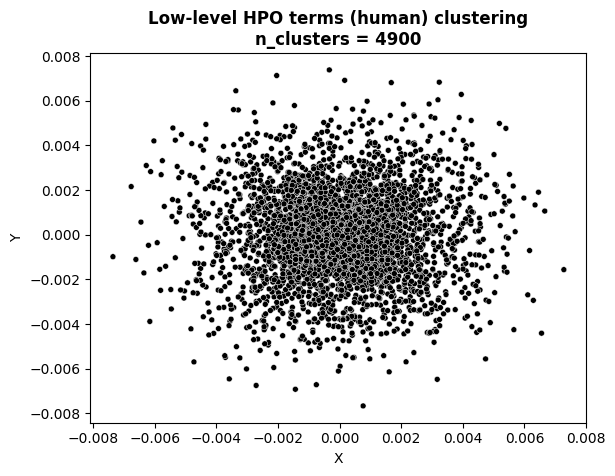

In [17]:
# plotting (human), distance within cluster as color hue, 
# cluster size as size hue

# color labels list
cols_h = np.array(clustered_hps.color.tolist())
human_colors = np.where(cols_h == "nan", "black", cols_h)
human_sizes = clustered_hps.cluster_size.tolist()

sns.scatterplot(
    data=clustered_hps,
    x="x",
    y="y",
    color="k",
    size=3,
    legend=False
)

plt.xlabel("X")
plt.ylabel("Y")
plt.title(
    f"Low-level HPO terms (human) clustering\nn_clusters = {best_n_clusters_h}",
    weight="bold"
)

plt.savefig(
    f"{PLOTS_DIR}/concord_33_human_clustered",
    bbox_inches="tight",
    dpi=800
)

plt.show()

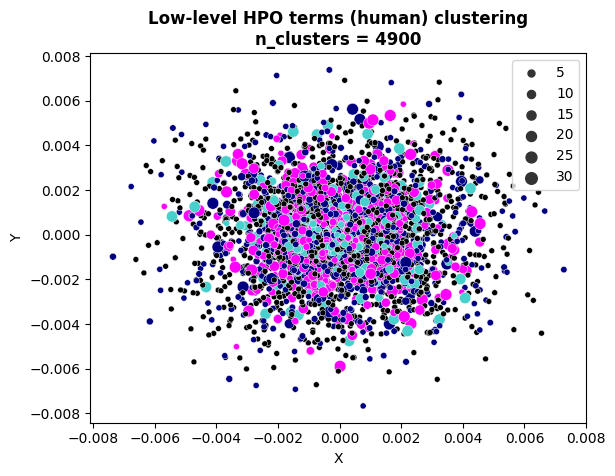

In [18]:
# plotting (human), distance within cluster as color hue, 
# cluster size as size hue

# color labels list
cols_h = np.array(clustered_hps.color.tolist())
human_colors = np.where(cols_h == "nan", "black", cols_h)
human_sizes = clustered_hps.cluster_size.tolist()

sns.scatterplot(
    data=clustered_hps,
    x="x",
    y="y",
    color=human_colors,
    size=human_sizes,
    legend=True
)

plt.xlabel("X")
plt.ylabel("Y")
plt.title(
    f"Low-level HPO terms (human) clustering\nn_clusters = {best_n_clusters_h}",
    weight="bold"
)

plt.savefig(
    f"{PLOTS_DIR}/concord_35_human_clustered_hue",
    bbox_inches="tight",
    dpi=800
)

plt.show()

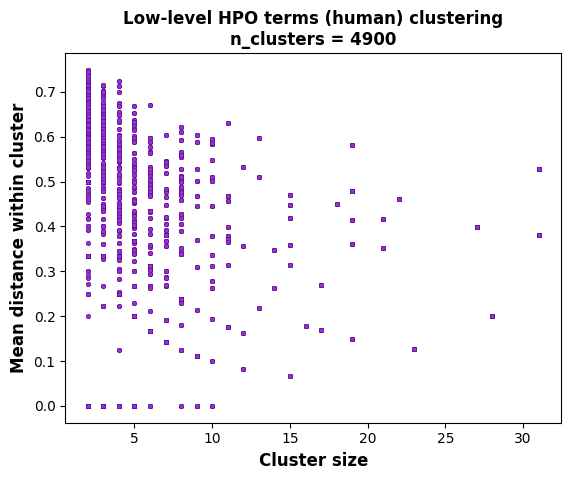

In [19]:
sns.scatterplot(
    data=clustered_hps,
    x="cluster_size",
    y="distance_within_cluster",
    s=10, c="darkorchid",
    edgecolor="indigo"
)

plt.xlabel(
    "Cluster size",
    size=12,
    weight="bold"
)
plt.ylabel(
    "Mean distance within cluster",
    size=12,
    weight="bold"
)
plt.title(
    f"Low-level HPO terms (human) clustering\nn_clusters = {best_n_clusters_h}",
    weight="bold"
)

plt.savefig(
    f"{PLOTS_DIR}/concord_37_human_custer_size_distance",
    bbox_inches="tight",
    dpi=800
)

plt.show()

/tmp/ipykernel_4948/1211887098.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/tmp/ipykernel_4948/1211887098.py:17: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(
/tmp/ipykernel_4948/1211887098.py:33: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.

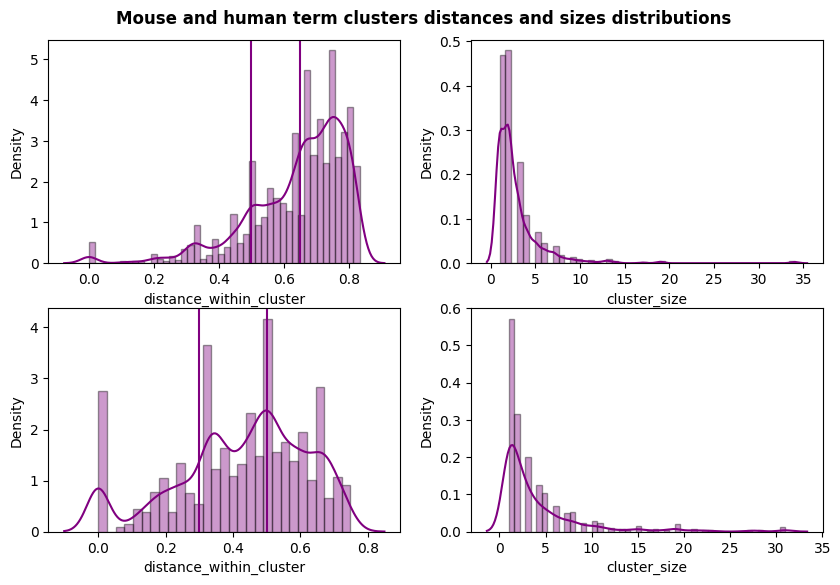

In [20]:
plt.figure(figsize=(10, 6))

dist_set = {
    "color": "purple",
    "hist_kws": {"edgecolor": "black"}
}

plt.subplot(2, 2, 2)

sns.distplot(
    clustered_mps.cluster_size,
    **dist_set
)

plt.subplot(2, 2, 1)

sns.distplot(
    clustered_mps.distance_within_cluster,
    **dist_set
)

plt.axvline(
    x=0.5,
    c="purple"
)
plt.axvline(
    x=0.65,
    c="purple"
)

plt.subplot(2, 2, 4)

sns.distplot(
    clustered_hps.cluster_size,
    **dist_set
)

plt.subplot(2, 2, 3)

sns.distplot(
    clustered_hps.distance_within_cluster,
    **dist_set
)

plt.axvline(
    x=0.3,
    c="purple"
)
plt.axvline(
    x=0.5,
    c="purple"
)

plt.subplots_adjust(top=0.93)

plt.suptitle(
    "Mouse and human term clusters distances and sizes distributions",
    weight="bold"
)

plt.savefig(
    f"{PLOTS_DIR}/concord_38_human_mouse_cluster_parameters",
    bbox_inches="tight",
    dpi=800
)

plt.show()

In [ ]:
sns.scatterplot(
    data=clustered_hps,
    x="cluster_size",
    y="distance_within_cluster",
    s=10, c="darkorchid",
    edgecolor="indigo"
)

plt.xlabel(
    "Cluster size",
    size=12,
    weight="bold"
)
plt.ylabel(
    "Mean distance within cluster",
    size=12,
    weight="bold"
)
plt.title(
    f"Low-level HPO terms (human) clustering\nn_clusters = {best_n_clusters_h}",
    weight="bold"
)

plt.savefig(
    f"{PLOTS_DIR}/concord_37_human_custer_size_distance",
    bbox_inches="tight",
    dpi=800
)

plt.show()

<AxesSubplot: xlabel='cluster_size', ylabel='distance_within_cluster'>

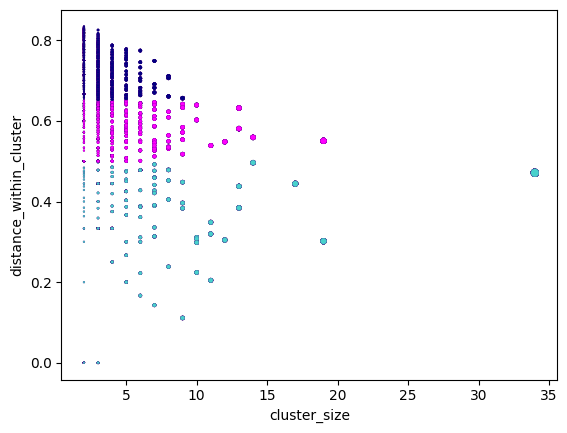

In [60]:
clustered_mps["color"] = clustered_mps.color.fillna("black")

sns.scatterplot(
    data=clustered_mps[~clustered_mps.distance_within_cluster.isna()],
    x="cluster_size",
    y="distance_within_cluster",
    s=clustered_mps[~clustered_mps.distance_within_cluster.isna()].cluster_size.tolist(), 
    color=clustered_mps[~clustered_mps.distance_within_cluster.isna()].color.tolist(),
    edgecolor="indigo"
)

<AxesSubplot: xlabel='cluster_size', ylabel='distance_within_cluster'>

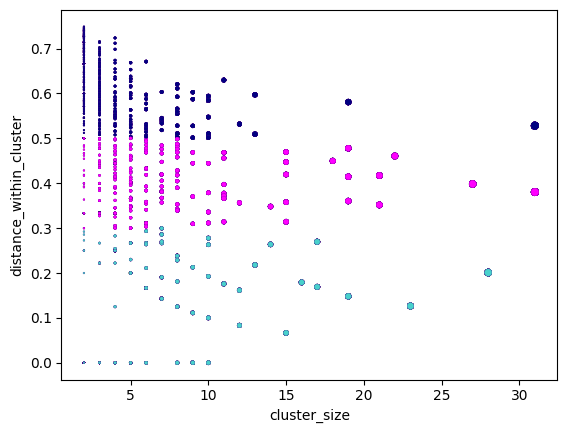

In [59]:
clustered_hps["color"] = clustered_hps.color.fillna("black")

sns.scatterplot(
    data=clustered_hps[~clustered_hps.distance_within_cluster.isna()],
    x="cluster_size",
    y="distance_within_cluster",
    s=clustered_hps[~clustered_hps.distance_within_cluster.isna()].cluster_size.tolist(), 
    color=clustered_hps[~clustered_hps.distance_within_cluster.isna()].color.tolist(),
    edgecolor="indigo"
)

Adding information to clusters: root distance, leaf distance, system term (if possible)